In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
# from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.utils.multiclass import unique_labels

from model_comparison_visuals import ModelComparisonVisualizer
from confusion_matrix_visuals import complete_cm_analysis

import warnings
warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv("../heartDisease_dataset_TP.csv")

In [ ]:
data.head()

# Pipeline with KNN, Iterative Imputers and discretised contiuous variables

In [ ]:
def group_age(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=['age'])

    X['age'] = pd.cut(
        X['age'],
        bins = [0, 50, 59, 100],
        labels = ['up to 50 years', '50-59 years', '59 years more'],
        right=False
    )

    return X.to_numpy().reshape(-1,1)

In [ ]:
def group_trestbps(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=['trestbps'])

    X['trestbps'] = pd.cut(
        X['trestbps'],
        bins = [-np.inf, 120, 139, np.inf],
        labels = ['normal', 'prehypertension', 'hypertension'],
        right=False
    )

    return X.to_numpy().reshape(-1,1)
        

In [ ]:
def group_chol(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns = ['chol'])

    X['chol'] = pd.cut(
        X['chol'],
        bins = [-np.inf, 120, 139, np.inf],
        labels = ['low', 'moderate', 'high'],
        right=False
    )

    return X.to_numpy().reshape(-1,1)

In [ ]:
def group_thalach(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns = ['thalach'])

    X['thalach'] = pd.cut(
        X['thalach'],
        bins = [-np.inf, 100, 140, np.inf],
        labels = ['low', 'moderate', 'high'],
        right=False
    )

    return X.to_numpy().reshape(-1,1)

In [ ]:
def group_oldpeak(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=['oldpeak'])

    X['oldpeak'] = pd.cut(
        X['oldpeak'],
        bins = [-np.inf, 100, 140, np.inf],
        labels = ['normal', 'moderate', 'severe'],
        right=False
    )

    return X.to_numpy().reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis = 1),
    data['target'],
    test_size=0.25,
    random_state=0
)

X_train.shape, X_test.shape


In [ ]:
X_test

In [10]:
age_transformer = FunctionTransformer(group_age, validate=False)
trestbps_transformer = FunctionTransformer(group_trestbps, validate=False)
chol_transformer = FunctionTransformer(group_chol, validate=False)
thalach_transformer = FunctionTransformer(group_thalach, validate=False)
oldpeak_transformer = FunctionTransformer(group_oldpeak, validate=False)

In [11]:
age_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=0)),
    ('transformer', age_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
    
trestbps_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', trestbps_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
    
chol_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, 
                              weights='uniform',
                              metric='nan_euclidean',
                              add_indicator=False
                              )),
    ('transformer', chol_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

thalach_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, 
                              weights='uniform',
                              metric='nan_euclidean',
                              add_indicator=False
                              )),
    ('transformer', thalach_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

oldpeak_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', oldpeak_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
    
categorical_features = ['thal', 'cp', 'slope', 'exang', 'ca', 'fbs', 'sex', 'restecg']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipeline, ['age']),
    ('trestbps', trestbps_pipeline, ['trestbps']),
    ('chol', chol_pipeline, ['chol']),
    ('thalach', thalach_pipeline, ['thalach']),
    ('oldpeak', oldpeak_pipeline, ['oldpeak']),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

In [12]:
models = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'model__C':[0.1, 1, 10],
            'model__solver': ['liblinear', 'saga'],
            'model__penalty': ['l1', 'l2']
        }
    },
    'decision_tree':{
        'model': DecisionTreeClassifier(random_state=0),
        'params': {
            'model__max_depth': [3,5,10,None],
            'model__min_samples_split': [2,5,10],
            'model__min_samples_leaf': [1,2,4],
            'model__criterion': ['gini', 'entropy']
        }
    },
    'explainable_bm': {
        'model': ExplainableBoostingClassifier(random_state=0),
        'params': {
            'model__max_bins': [128,256],
            'model__max_rounds': [1000,2000],
            'model__interactions': [5,10,15],
            'model__learning_rate': [0.01, 0.05]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=0),
        'params': {
            'model__n_estimators': [100,150,200],
            'model__max_depth': [3,4,5],
            'model__min_samples_split': [2,5,8],
            'model__min_samples_leaf': [1,2,4],
            'model__max_features': ['sqrt', 'log2']
        }
    }
}


In [13]:
results = {}
best_score = -np.inf
best_model = None
best_model_name = ""
best_params = {}

In [14]:
for model_name, model_info in models.items():
    print(f"Training {model_name.replace('_', ' ').title()}...")

    if model_name == 'explainable_bm':
        pipe = Pipeline([
            ('model', model_info['model'])
        ])
    else: 
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_info['model'])
        ])

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1_weighted',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'roc_auc': 'roc_auc_ovr_weighted'
    }

    grid_search = GridSearchCV(
        pipe,
        model_info['params'],
        cv=5,
        scoring=scoring,
        refit='f1',
        n_jobs=-1,
        verbose=0,
        error_score='raise'
    
   )

    grid_search.fit(X_train, y_train)

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_,
        'cv_results': grid_search.cv_results_
    }

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_model_name = model_name
        best_params = grid_search.best_params_

    print(f"  Best CV Accuracy Score: {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}\n")

Training Logistic Regression...
  Best CV Accuracy Score: 0.8500
  Best Parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Training Decision Tree...
  Best CV Accuracy Score: 0.8130
  Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}

Training Explainable Bm...
  Best CV Accuracy Score: 0.8365
  Best Parameters: {'model__interactions': 5, 'model__learning_rate': 0.01, 'model__max_bins': 128, 'model__max_rounds': 1000}

Training Random Forest...
  Best CV Accuracy Score: 0.8589
  Best Parameters: {'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 150}



# Model Comparison Results    

In [ ]:
best_model.fit(X_train, y_train)

In [16]:
y_pred = best_model.predict(X_test)

In [17]:
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted')
}

In [18]:
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name.replace('_', ' ').title()}")
print(f"{'='*60}")
print("\nTest Set Performance")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")


BEST MODEL: Random Forest

Test Set Performance
  Accuracy: 0.8289
  F1 Score: 0.8278
  Precision: 0.8292
  Recall: 0.8289


In [19]:
cm = complete_cm_analysis()

🔍 Starting comprehensive confusion matrix analysis...

1. 📊 Side-by-Side Confusion Matrices


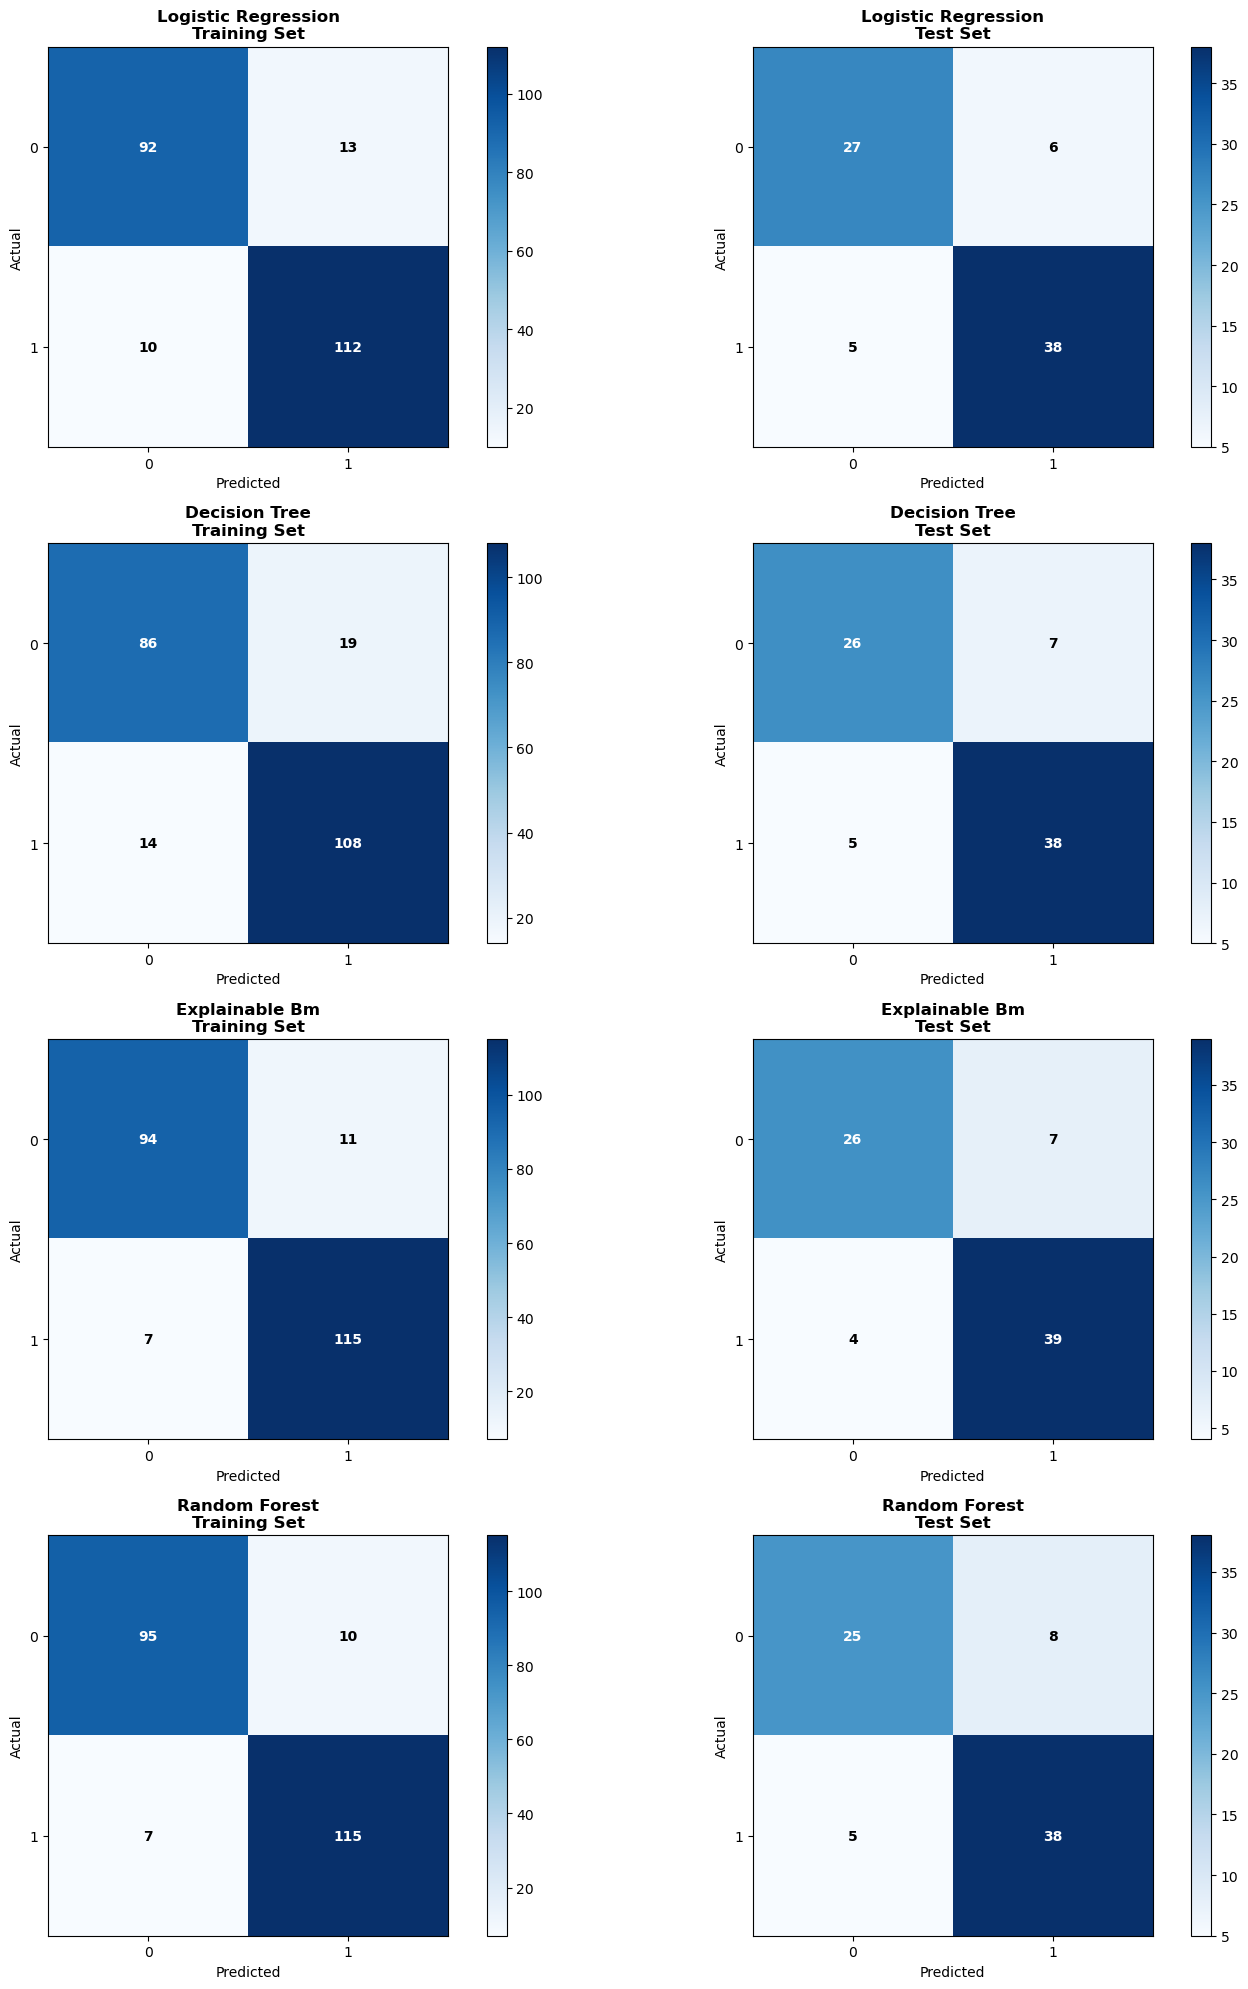


2. 📈 Normalized Confusion Matrices


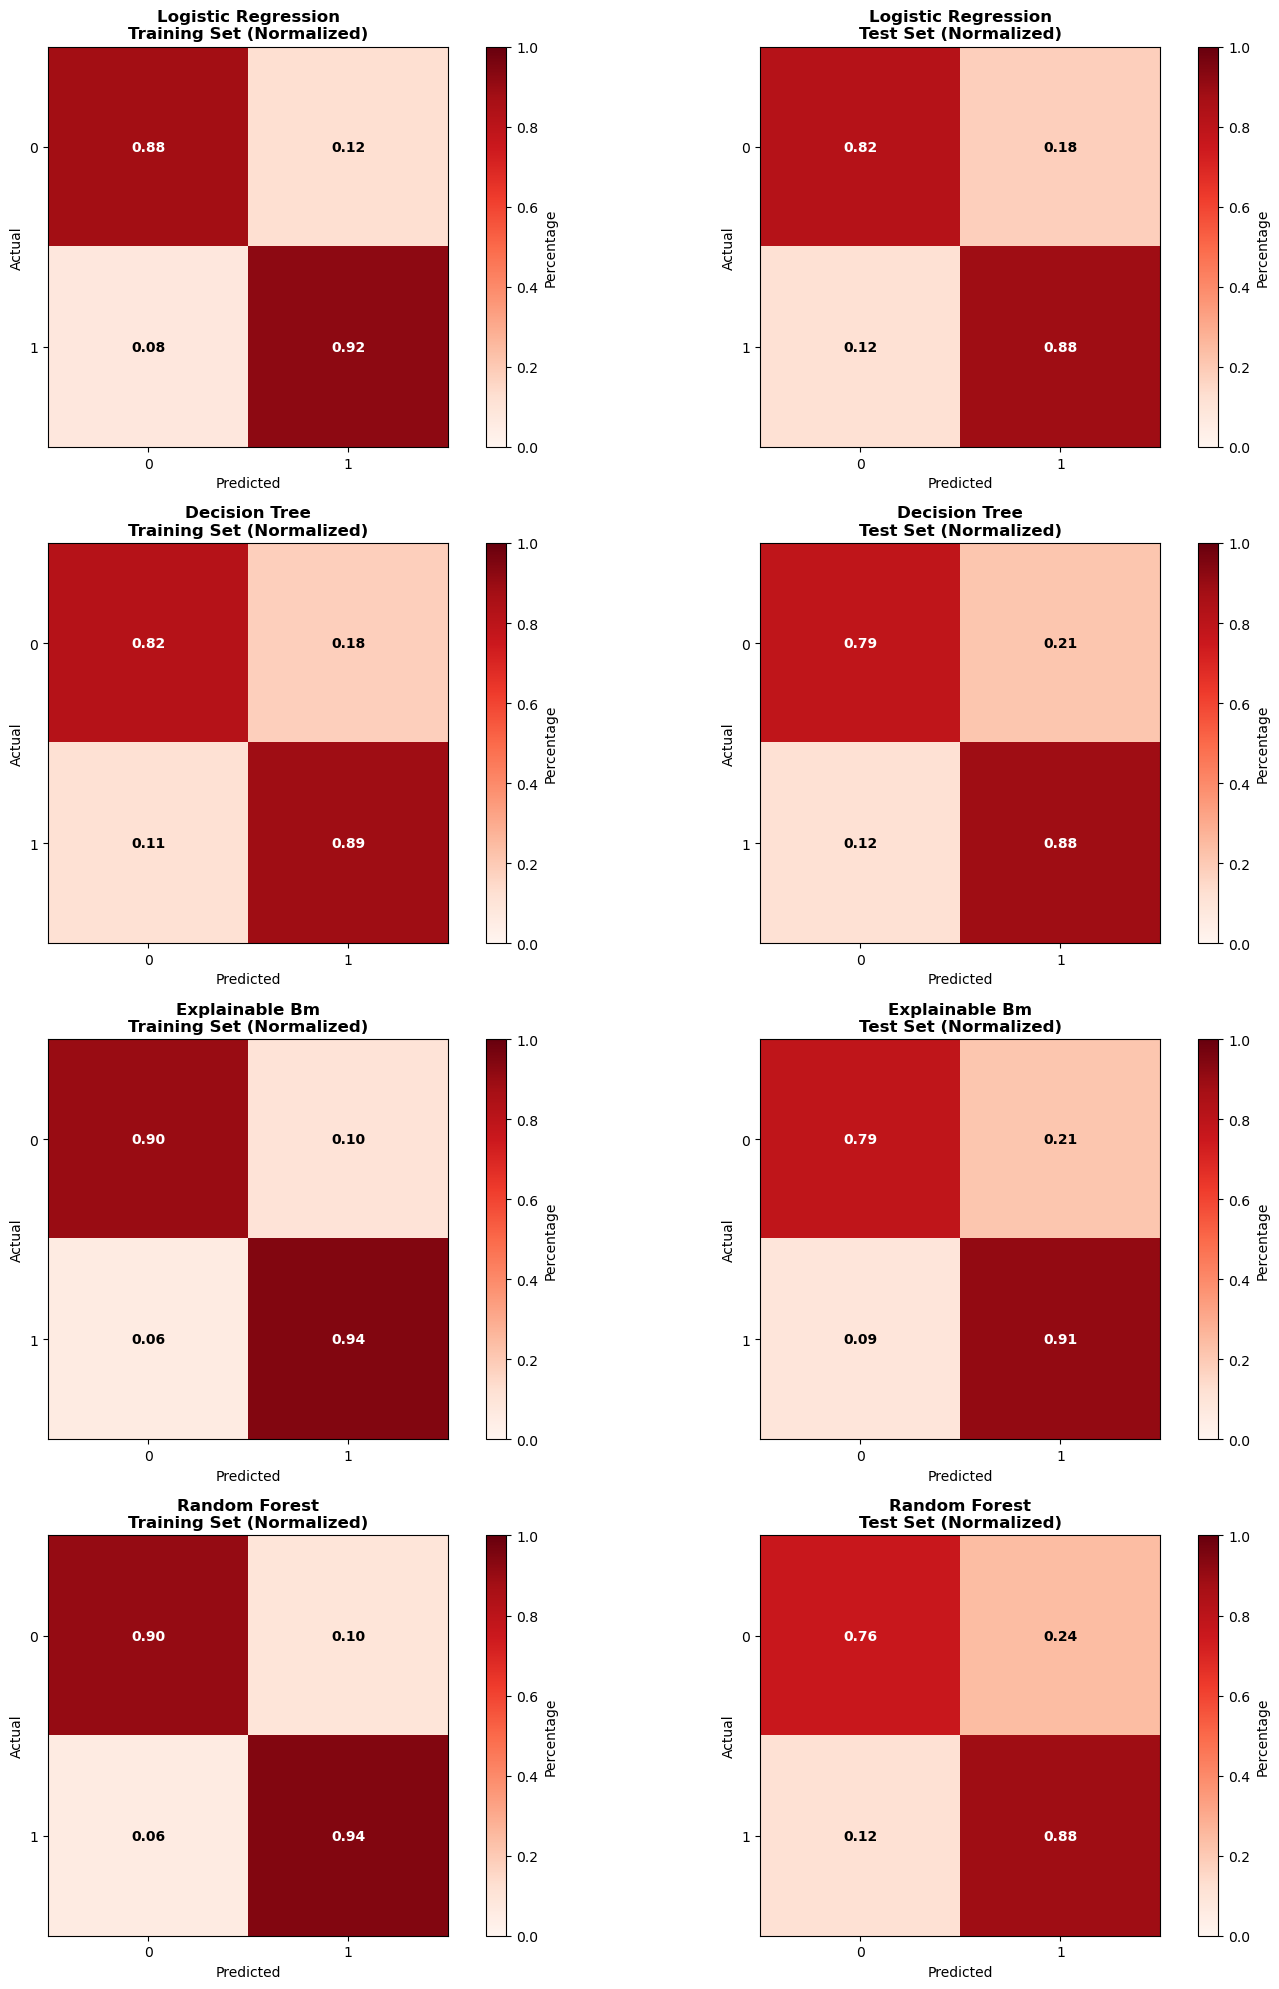


3. ⚖️  Overfitting Analysis (Difference Heatmaps)


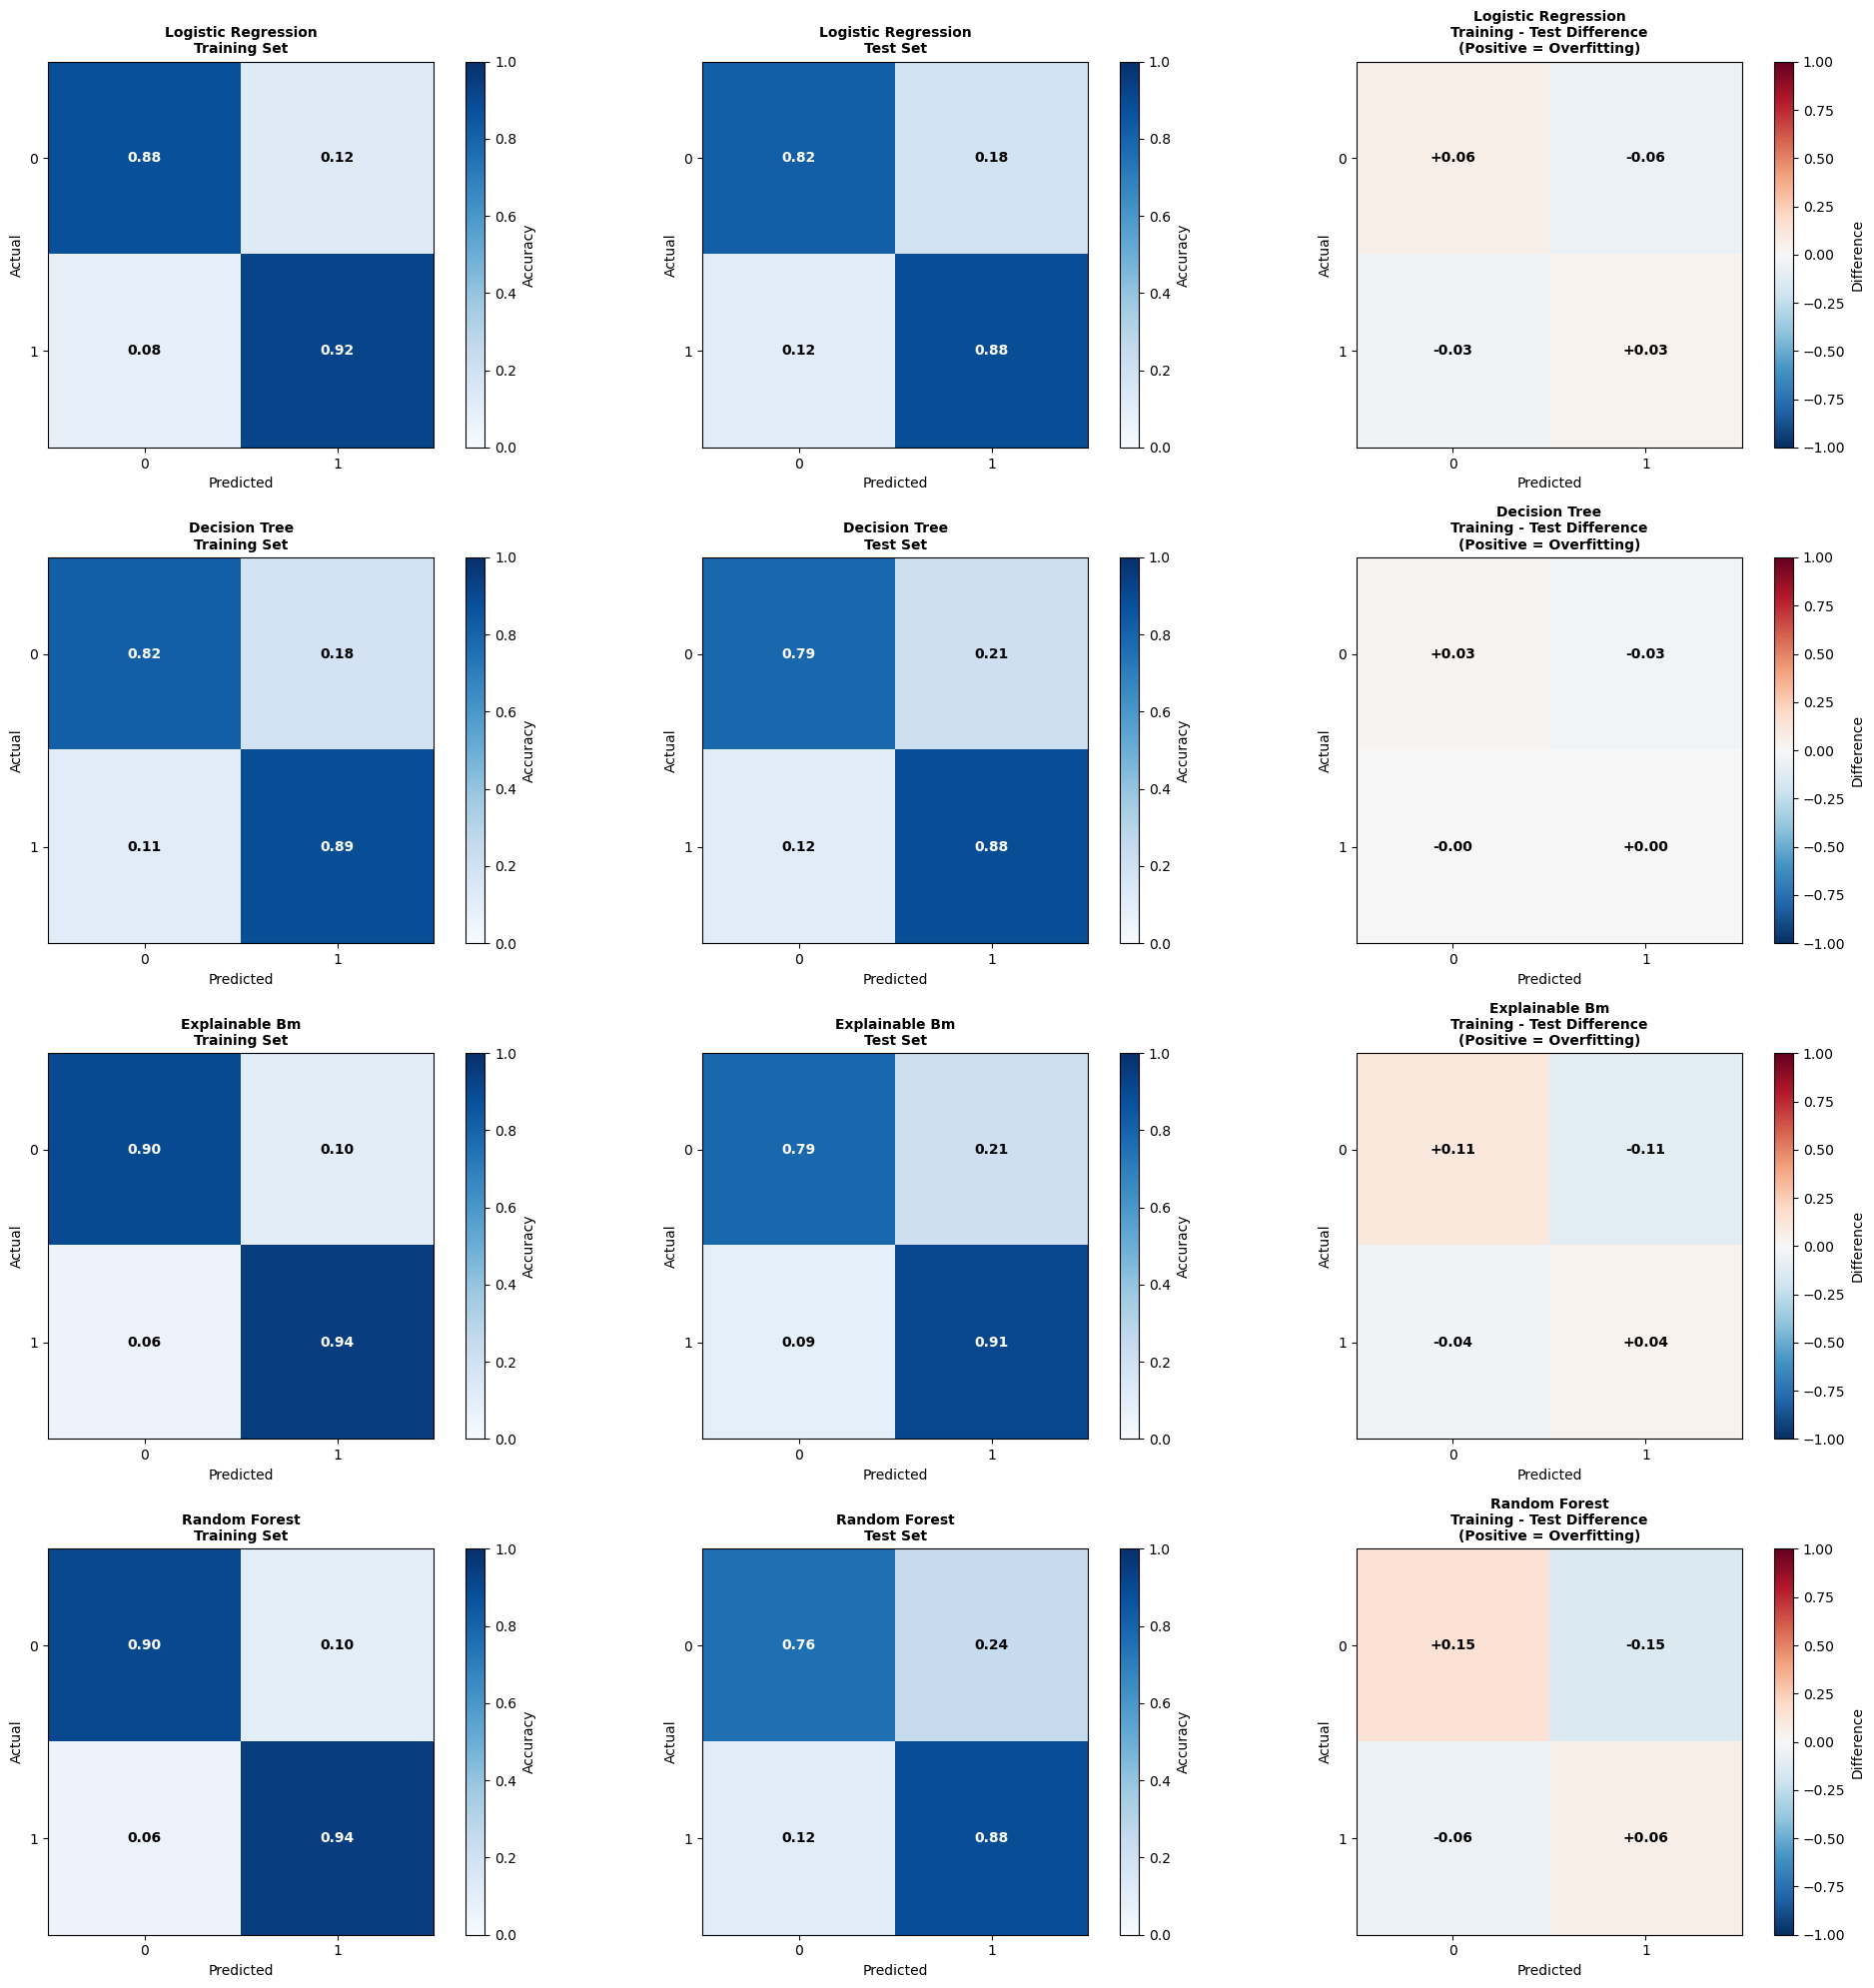


4. 📋 Statistical Summary


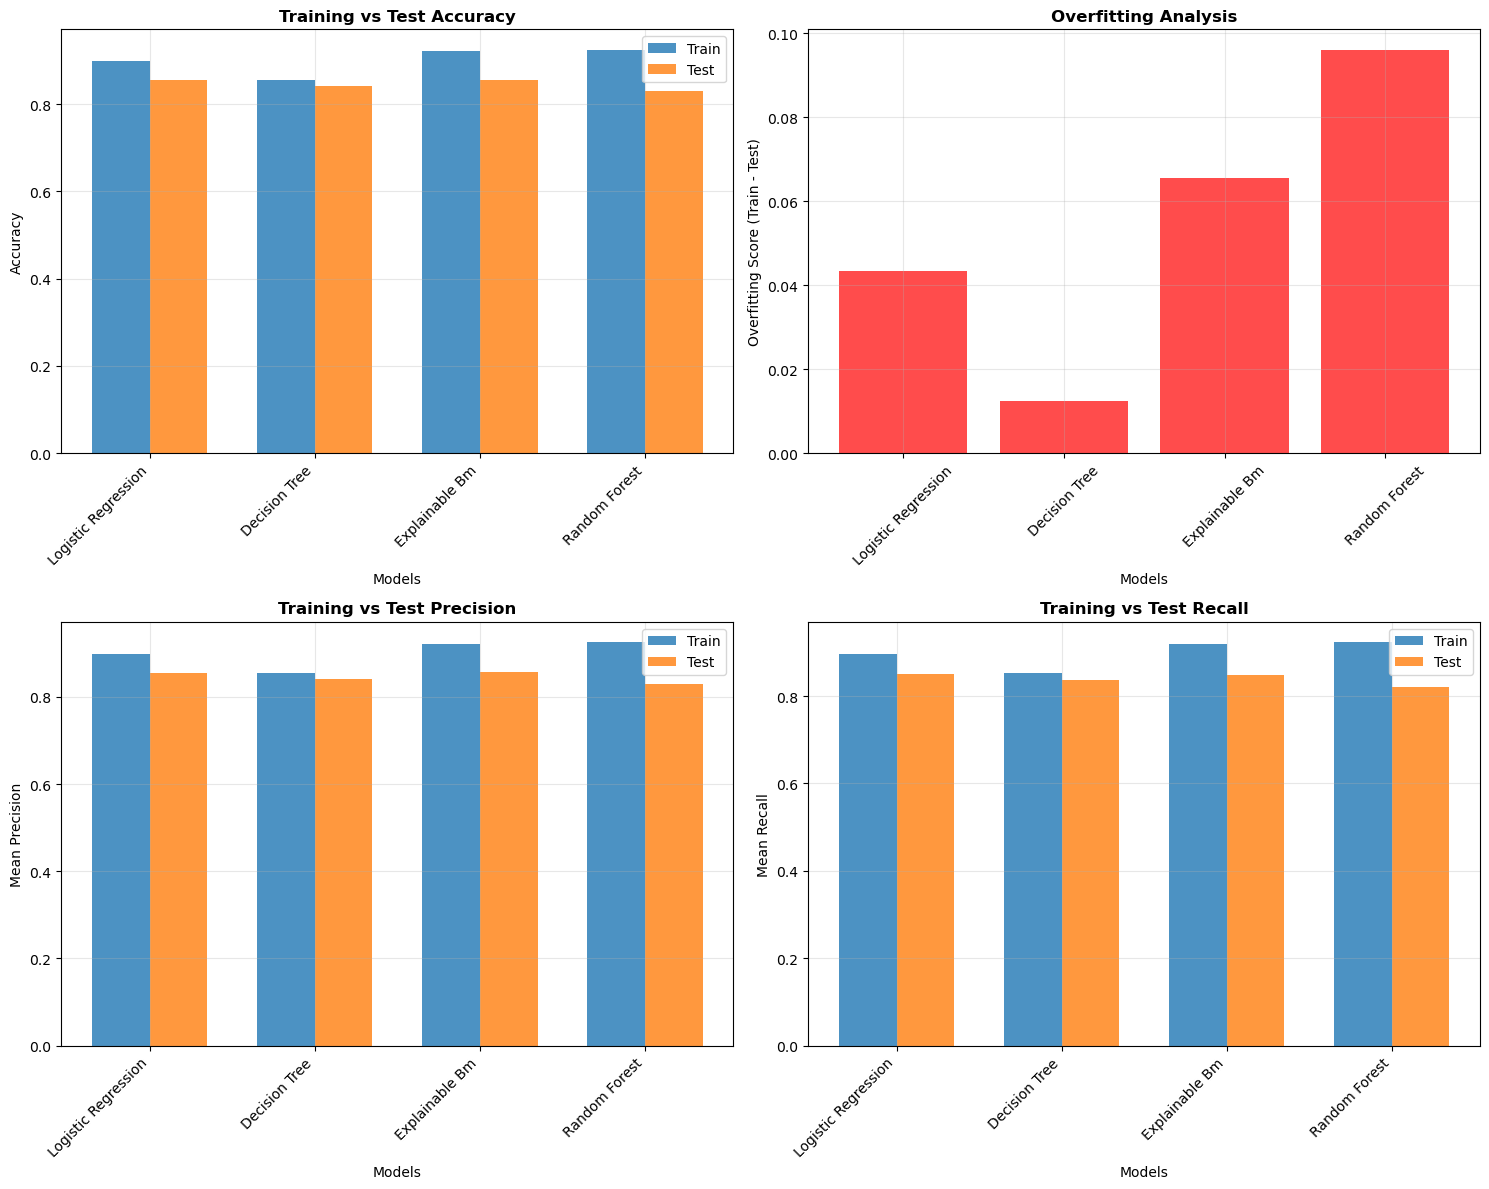


📊 Performance Statistics Summary:
              Model  Train_Accuracy  Test_Accuracy  Train_Precision_Mean  Test_Precision_Mean  Train_Recall_Mean  Test_Recall_Mean  Overfitting_Score
Logistic Regression          0.8987         0.8553                0.8990               0.8537             0.8971            0.8510             0.0434
      Decision Tree          0.8546         0.8421                0.8552               0.8416             0.8521            0.8358             0.0125
     Explainable Bm          0.9207         0.8553                0.9217               0.8572             0.9189            0.8474             0.0654
      Random Forest          0.9251         0.8289                0.9257               0.8297             0.9237            0.8206             0.0962

✅ Confusion matrix analysis completed!


In [20]:
cm.run_complete_cm_analysis(results, X_train, y_train,X_test, y_test)

In [21]:
MCV = ModelComparisonVisualizer()

📊 Starting model comparison analysis...

1. 📈 Generating comprehensive comparison dashboard...


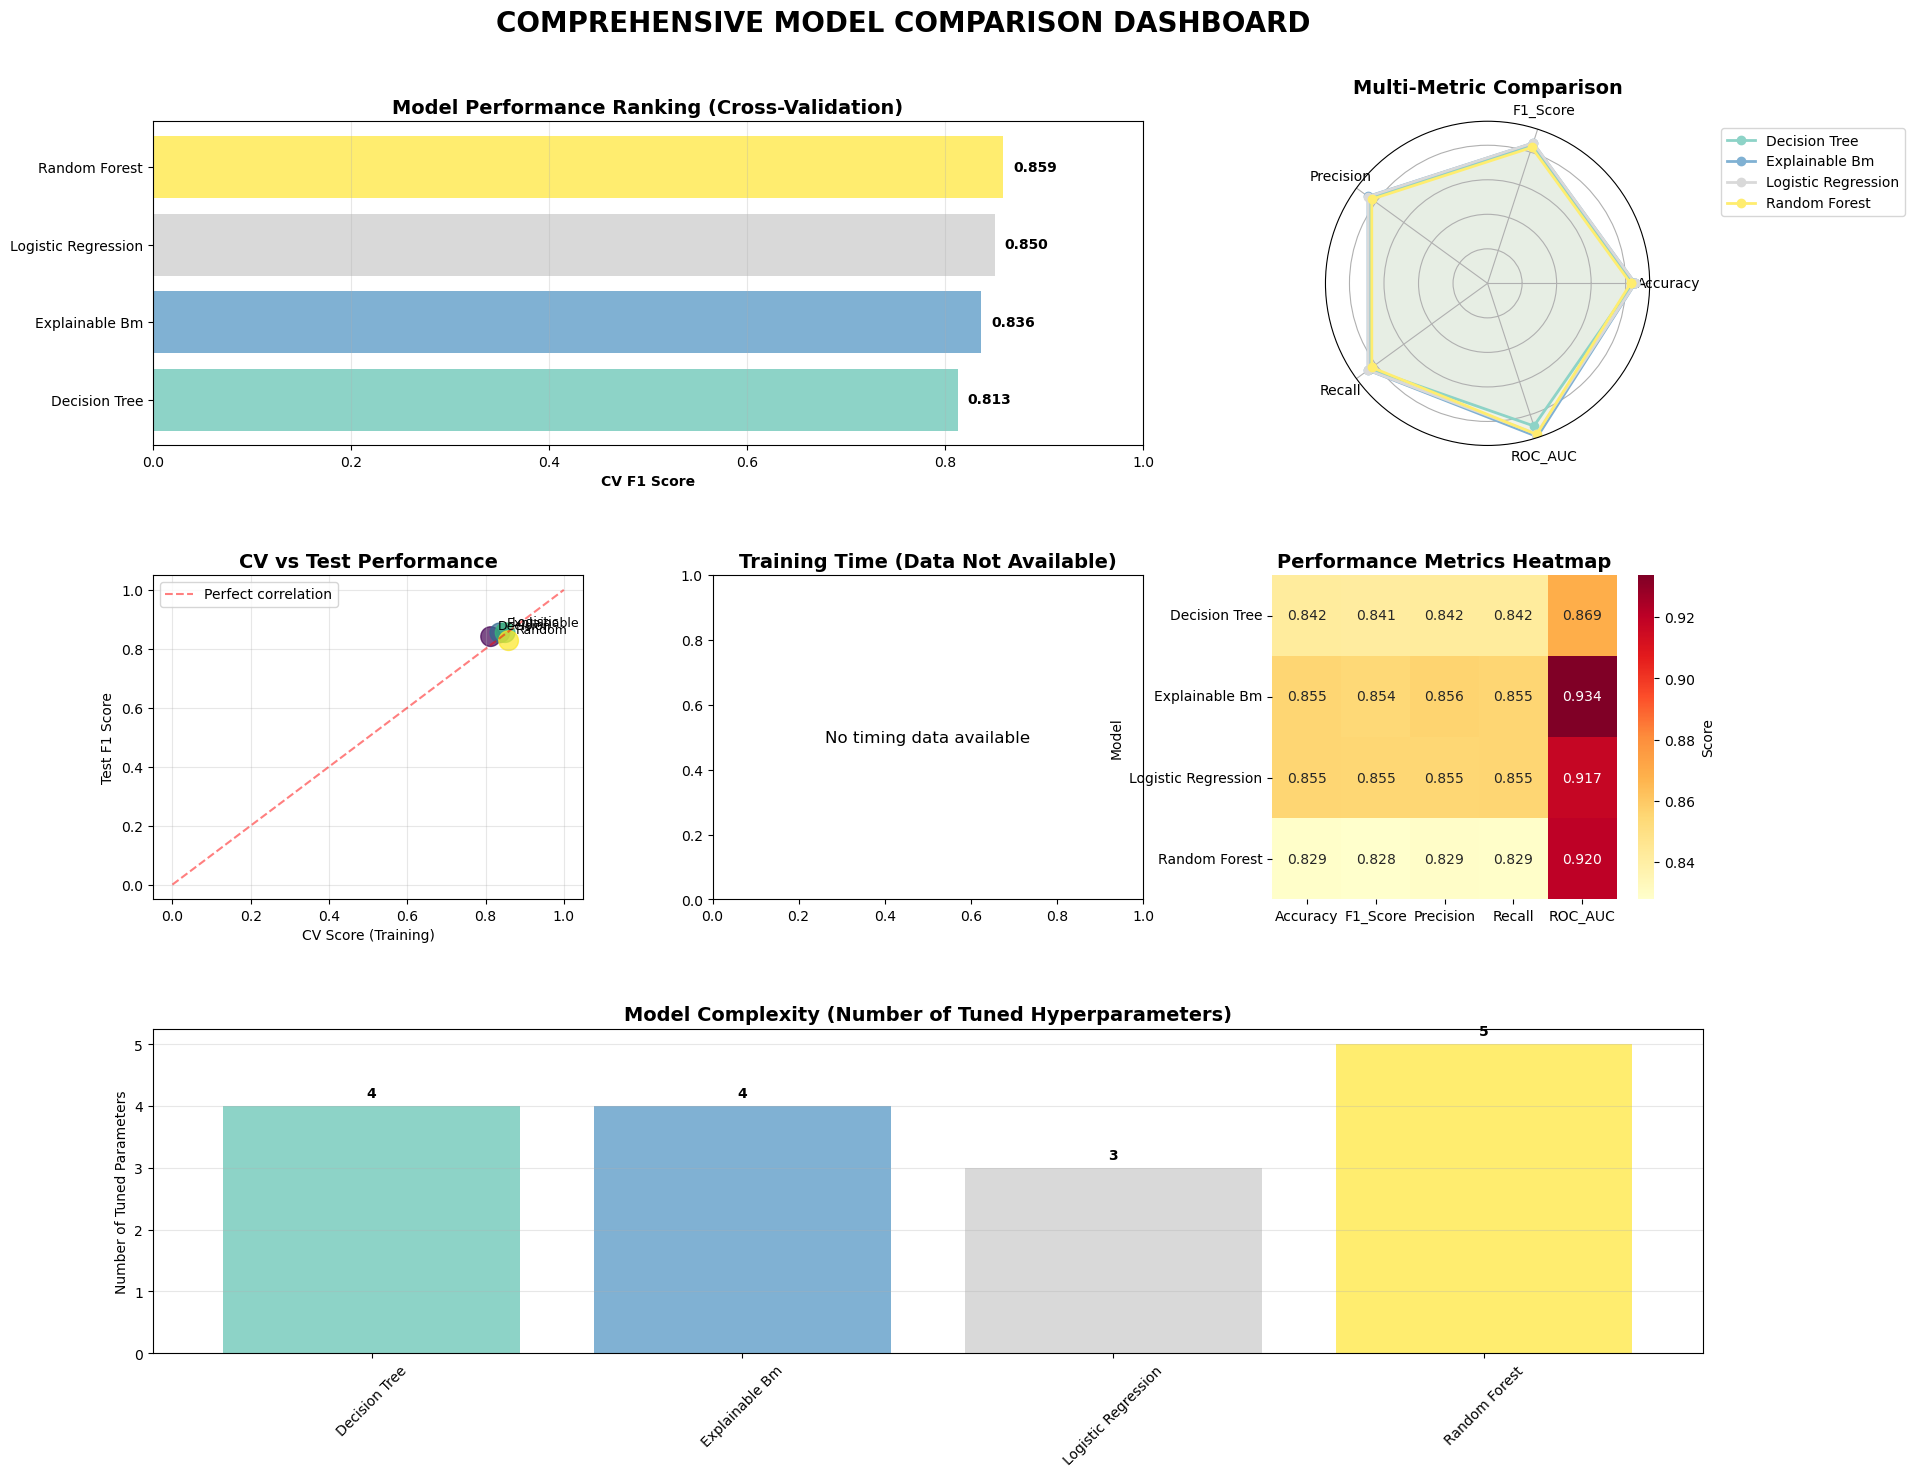


2. 📊 Creating individual model scorecards...


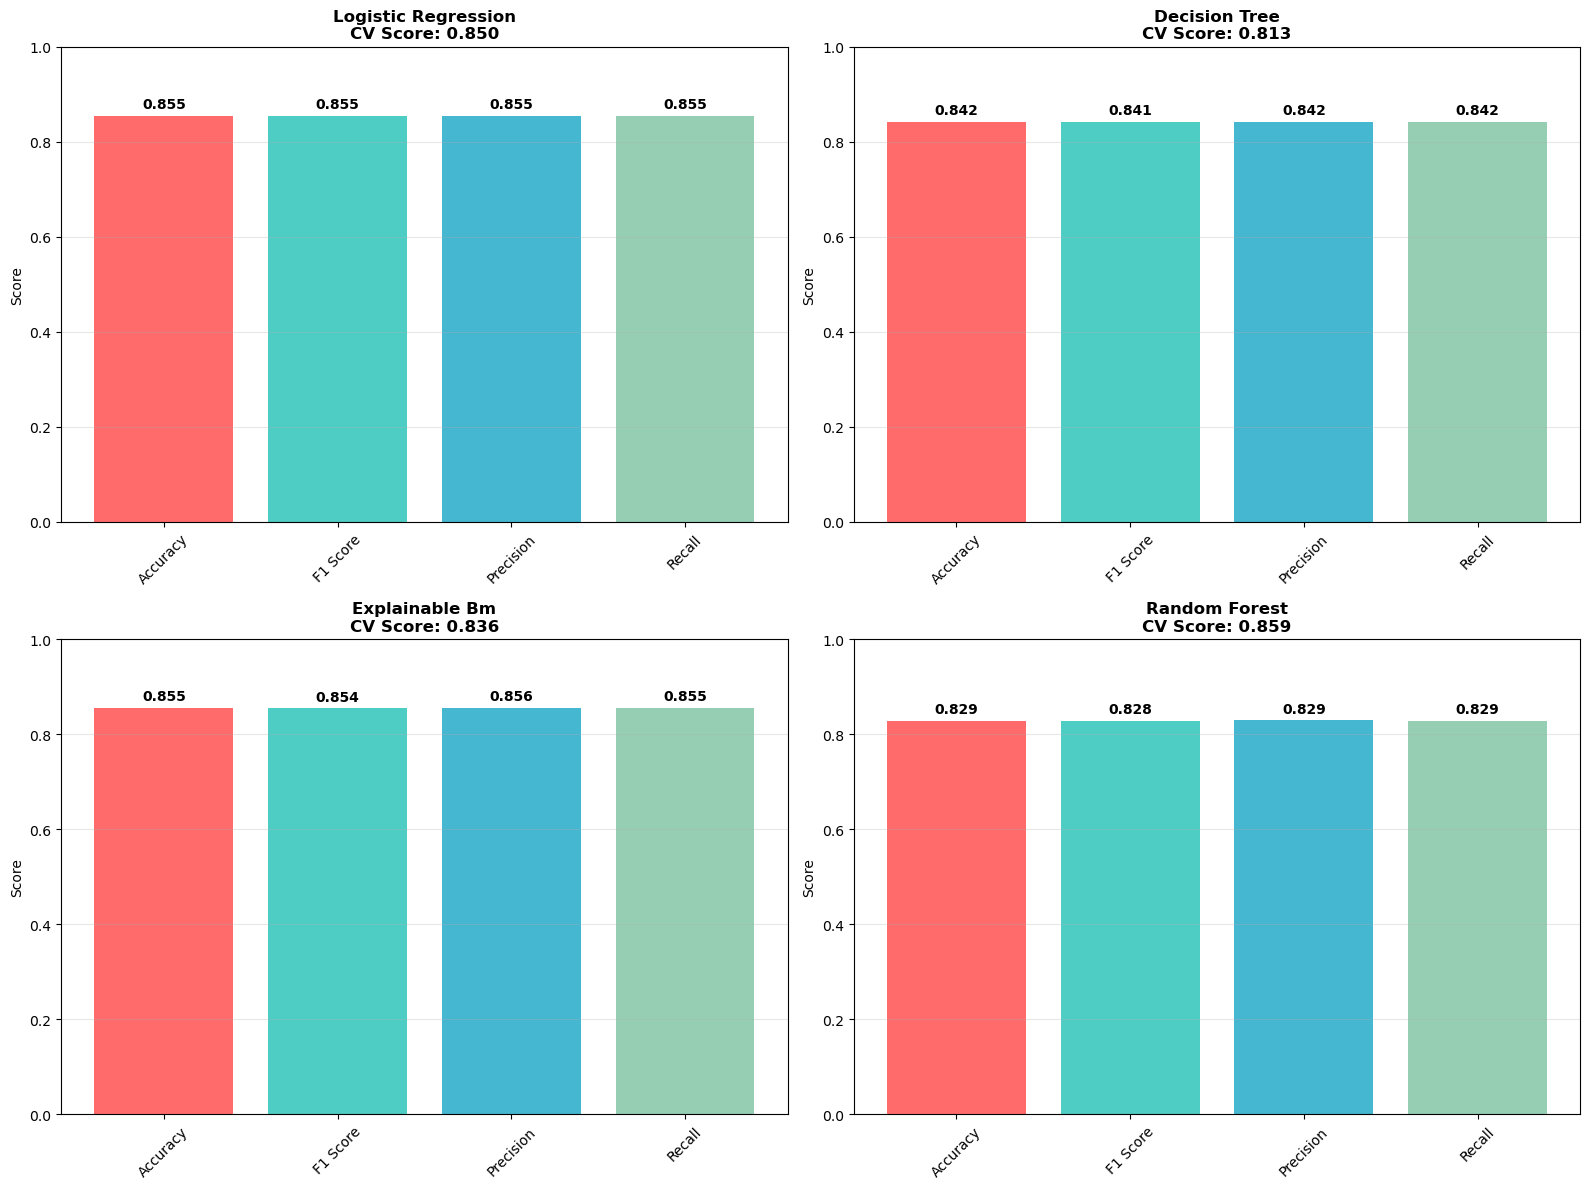


3. 📋 Generating performance trends...


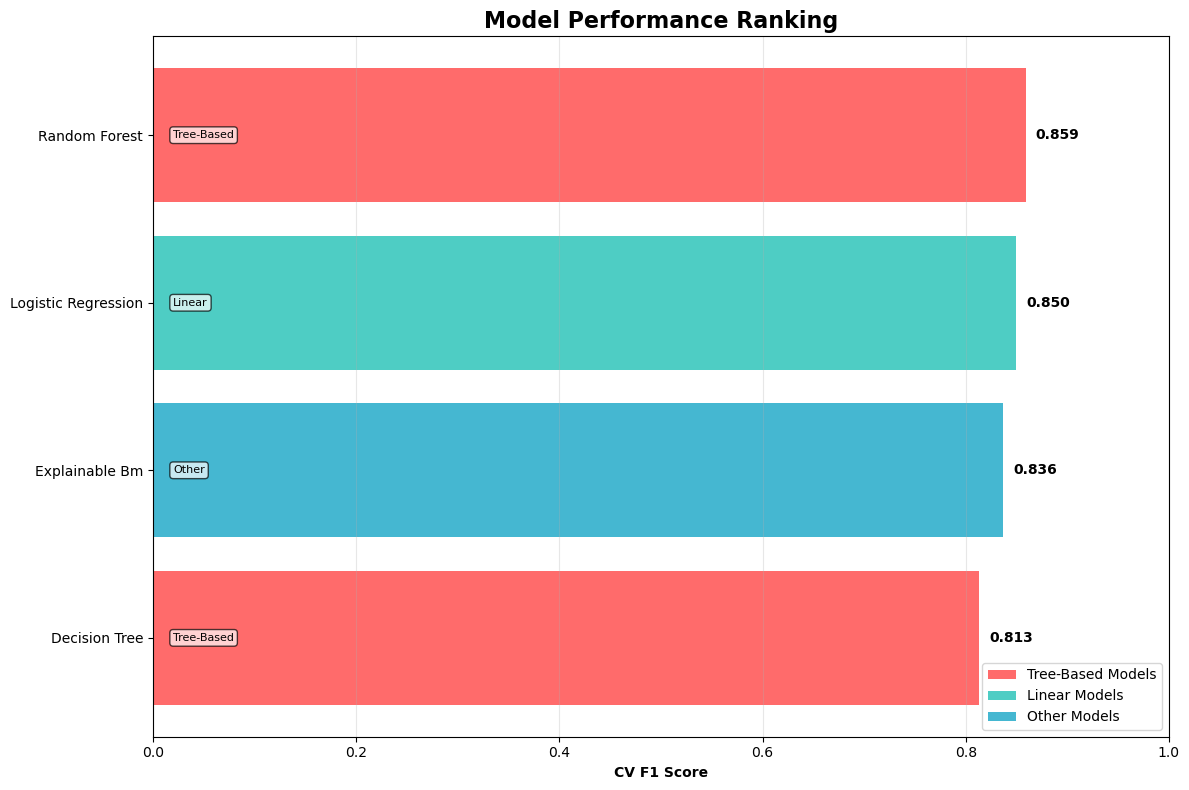


4. 🏆 Displaying ranking table...
🏆 FINAL MODEL RANKING 🏆
 Rank               Model CV_Score Accuracy F1_Score Precision Recall Fit_Time
    1       Random Forest   0.8589   0.8289   0.8278    0.8292 0.8289      N/A
    2 Logistic Regression   0.8500   0.8553   0.8550    0.8550 0.8553      N/A
    3      Explainable Bm   0.8365   0.8553   0.8543    0.8560 0.8553      N/A
    4       Decision Tree   0.8130   0.8421   0.8414    0.8420 0.8421      N/A

✅ Analysis complete!


,Model,CV_Score,Accuracy,F1_Score,Precision,Recall,ROC_AUC,Fit_Time,Best_Params
1,Decision Tree,0.812975,0.842105,0.841432,0.841954,0.842105,0.868922,0,"{'model__criterion': 'gini', 'model__max_depth..."
2,Explainable Bm,0.836487,0.855263,0.854256,0.856007,0.855263,0.933756,0,"{'model__interactions': 5, 'model__learning_ra..."
0,Logistic Regression,0.849969,0.855263,0.854982,0.855001,0.855263,0.917195,0,"{'model__C': 1, 'model__penalty': 'l2', 'model..."
3,Random Forest,0.858893,0.828947,0.827758,0.829233,0.828947,0.920014,0,"{'model__max_depth': 5, 'model__max_features':..."


In [22]:
MCV.run_complete_analysis(results, X_test, y_test, ascending=True)